CS-366 Data Visualization - Semester Project
Global Terrorism Database (GTD) Analysis

Taha Bin Hanif 458653
Muhammad Ahmed 456679
Muhammad Umer 456157

## 1. Setup and Installation

In [1]:
# Install required packages (run this first in Colab)
!pip install pandas numpy matplotlib seaborn plotly kaggle streamlit openpyxl -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.6 MB/s eta 0:00:00


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!



**Dataset:** Global Terrorism Database (GTD)  

In [6]:
import os
import pandas as pd

# ---- SET YOUR KAGGLE API KEY HERE ----
KAGGLE_USERNAME = "Taha Hanif"
KAGGLE_KEY = "KGAT_678fc01bf0f24d850df3ece58afc00b9"
# --------------------------------------

# Create the kaggle.json content
kaggle_content = f'''{{
  "username": "{KAGGLE_USERNAME}",
  "key": "{KAGGLE_KEY}"
}}'''

# Save it to ~/.kaggle/kaggle.json
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    f.write(kaggle_content)

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API key configured successfully.")

# Download the dataset
!kaggle datasets download -d START-UMD/gtd

# Unzip
!unzip gtd.zip -d gtd_data

# Load dataset
df_raw = pd.read_csv("gtd_data/globalterrorismdb_0718dist.csv", encoding="ISO-8859-1", low_memory=False)
print(f"Dataset loaded: {len(df_raw):,} rows")


Kaggle API key configured successfully.
Dataset URL: https://www.kaggle.com/datasets/START-UMD/gtd
License(s): other
  0% 0.00/28.7M [00:00<?, ?B/s]
100% 28.7M/28.7M [00:00<00:00, 1.18GB/s]
Archive:  gtd.zip
  inflating: gtd_data/globalterrorismdb_0718dist.csv  
Dataset loaded: 181,691 rows


In [8]:
# Load the data
def load_gtd_data(filename):
    """
    Load Global Terrorism Database
    """
    print("Loading Global Terrorism Database...")
    print("Source: START - National Consortium for the Study of Terrorism")
    print("-" * 60)

    # Try different encodings
    encodings = ['ISO-8859-1', 'latin1', 'utf-8', 'cp1252']

    df = None
    for encoding in encodings:
        try:
            df = pd.read_csv(filename, encoding=encoding, low_memory=False)
            print(f"✅ Loaded with {encoding} encoding")
            break
        except Exception as e:
            continue

    if df is None:
        raise Exception("Could not load the file with any encoding")

    print("-" * 60)
    print(f"✅ Data loaded successfully!")
    print(f"Total records: {len(df):,}")
    print(f"Columns: {len(df.columns)}")
    print(f"Year range: {df['iyear'].min()} - {df['iyear'].max()}")

    return df

# Load the data
filename = "gtd_data/globalterrorismdb_0718dist.csv"
df_raw = load_gtd_data(filename)

Loading Global Terrorism Database...
Source: START - National Consortium for the Study of Terrorism
------------------------------------------------------------
✅ Loaded with ISO-8859-1 encoding
------------------------------------------------------------
✅ Data loaded successfully!
Total records: 181,691
Columns: 135
Year range: 1970 - 2017


In [9]:
# Save raw data
df_raw.to_csv('gtd_raw.csv', index=False)
print("Raw data saved to 'gtd_raw.csv'")

# Display basic info
print(f"\nDataset Shape: {df_raw.shape}")
print(f"\nFirst 20 Columns:")
print(df_raw.columns[:20].tolist())

Raw data saved to 'gtd_raw.csv'

Dataset Shape: (181691, 135)

First 20 Columns:
['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended', 'resolution', 'country', 'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude', 'longitude', 'specificity', 'vicinity', 'location', 'summary', 'crit1']


In [10]:
# Preview the data
df_raw.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [11]:
# Key columns in GTD dataset
key_columns = [
    'iyear', 'imonth', 'iday',           # Date
    'country_txt', 'region_txt',          # Location
    'city', 'latitude', 'longitude',      # Coordinates
    'attacktype1_txt',                    # Attack type
    'targtype1_txt', 'target1',           # Target
    'gname',                              # Group name
    'weaptype1_txt',                      # Weapon
    'nkill', 'nwound',                    # Casualties
    'success', 'suicide'                  # Attack details
]

# Check which columns exist
existing_cols = [col for col in key_columns if col in df_raw.columns]
print(f"Key columns found: {len(existing_cols)}/{len(key_columns)}")
print(existing_cols)

Key columns found: 17/17
['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'city', 'latitude', 'longitude', 'attacktype1_txt', 'targtype1_txt', 'target1', 'gname', 'weaptype1_txt', 'nkill', 'nwound', 'success', 'suicide']


In [12]:
# Data types and info
print("Data Types (first 20 columns):")
print(df_raw.dtypes[:20])

Data Types (first 20 columns):
eventid          int64
iyear            int64
imonth           int64
iday             int64
approxdate      object
extended         int64
resolution      object
country          int64
country_txt     object
region           int64
region_txt      object
provstate       object
city            object
latitude       float64
longitude      float64
specificity    float64
vicinity         int64
location        object
summary         object
crit1            int64
dtype: object


---
## 3. Data Cleaning & Wrangling

### 3.1 Select Relevant Columns

In [13]:
# Select relevant columns for analysis
columns_to_keep = [
    # Identifiers
    'eventid',

    # Date
    'iyear', 'imonth', 'iday',

    # Location
    'country_txt', 'region_txt', 'city', 'latitude', 'longitude',
    'specificity',

    # Attack details
    'success', 'suicide', 'attacktype1_txt', 'attacktype1',

    # Target
    'targtype1_txt', 'targtype1', 'target1', 'natlty1_txt',

    # Perpetrator
    'gname', 'guncertain1', 'nperps',

    # Weapon
    'weaptype1_txt', 'weaptype1',

    # Casualties
    'nkill', 'nwound', 'propextent_txt',

    # Additional
    'ishostkid', 'nhostkid', 'ransom', 'ransomamt'
]

# Keep only existing columns
columns_to_keep = [col for col in columns_to_keep if col in df_raw.columns]

print(f"Columns before reduction: {len(df_raw.columns)}")
df = df_raw[columns_to_keep].copy()
print(f"Columns after reduction: {len(df.columns)}")
print(f"\nSelected columns: {df.columns.tolist()}")

Columns before reduction: 135
Columns after reduction: 30

Selected columns: ['eventid', 'iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'city', 'latitude', 'longitude', 'specificity', 'success', 'suicide', 'attacktype1_txt', 'attacktype1', 'targtype1_txt', 'targtype1', 'target1', 'natlty1_txt', 'gname', 'guncertain1', 'nperps', 'weaptype1_txt', 'weaptype1', 'nkill', 'nwound', 'propextent_txt', 'ishostkid', 'nhostkid', 'ransom', 'ransomamt']


### 3.2 Missing Values Analysis

In [14]:
# Check missing values
missing_stats = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing %', ascending=False)

print("Missing Values Analysis:")
print("=" * 50)
print(missing_stats[missing_stats['Missing Count'] > 0])

Missing Values Analysis:
                Missing Count  Missing %
ransomamt              180341      99.26
nhostkid               168119      92.53
propextent_txt         117626      64.74
ransom                 104310      57.41
nperps                  71115      39.14
nwound                  16311       8.98
nkill                   10313       5.68
longitude                4557       2.51
latitude                 4556       2.51
natlty1_txt              1559       0.86
target1                   638       0.35
city                      435       0.24
guncertain1               380       0.21
ishostkid                 178       0.10
specificity                 6       0.00


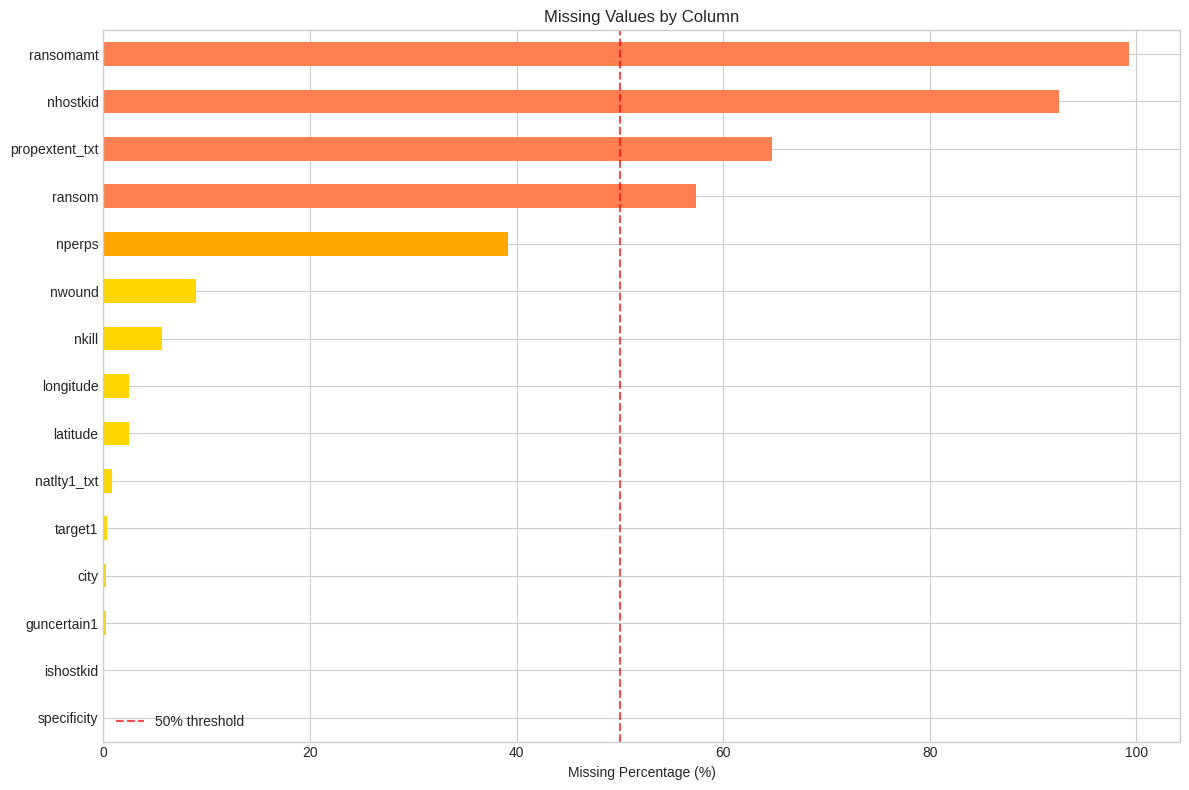

In [15]:
# Visualize missing values for key columns
plt.figure(figsize=(12, 8))
missing_pct = (df.isnull().sum() / len(df) * 100)
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=True)

if len(missing_pct) > 0:
    colors = ['coral' if x > 50 else 'orange' if x > 20 else 'gold' for x in missing_pct.values]
    missing_pct.plot(kind='barh', color=colors)
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Values by Column')
    plt.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='50% threshold')
    plt.legend()
    plt.tight_layout()
    plt.savefig('missing_values.png', dpi=150)
    plt.show()
else:
    print("No significant missing values found!")

### 3.3 Handle Missing Values

In [16]:
# Handle missing values
print("Handling missing values...")

# 1. Fill missing casualties with 0
df['nkill'] = df['nkill'].fillna(0)
df['nwound'] = df['nwound'].fillna(0)
print("  ✓ nkill, nwound: filled with 0")

# 2. Fill missing city with 'Unknown'
df['city'] = df['city'].fillna('Unknown')
print("  ✓ city: filled with 'Unknown'")

# 3. Fill missing group name
df['gname'] = df['gname'].fillna('Unknown')
print("  ✓ gname: filled with 'Unknown'")

# 4. Fill missing target
if 'target1' in df.columns:
    df['target1'] = df['target1'].fillna('Unknown')
    print("  ✓ target1: filled with 'Unknown'")

# 5. Handle missing dates
df['imonth'] = df['imonth'].replace(0, 1)  # Replace 0 with January
df['iday'] = df['iday'].replace(0, 1)      # Replace 0 with 1st
print("  ✓ imonth, iday: replaced 0 with 1")

# 6. Fill missing success with mode (most common value)
if 'success' in df.columns:
    df['success'] = df['success'].fillna(df['success'].mode()[0])
    print("  ✓ success: filled with mode")

# 7. Fill missing suicide with 0
if 'suicide' in df.columns:
    df['suicide'] = df['suicide'].fillna(0)
    print("  ✓ suicide: filled with 0")

print("\n✅ Missing values handled!")

Handling missing values...
  ✓ nkill, nwound: filled with 0
  ✓ city: filled with 'Unknown'
  ✓ gname: filled with 'Unknown'
  ✓ target1: filled with 'Unknown'
  ✓ imonth, iday: replaced 0 with 1
  ✓ success: filled with mode
  ✓ suicide: filled with 0

✅ Missing values handled!


### 3.4 Feature Engineering

In [17]:
# Create date column
df['date'] = pd.to_datetime(
    df['iyear'].astype(str) + '-' +
    df['imonth'].astype(str).str.zfill(2) + '-' +
    df['iday'].astype(str).str.zfill(2),
    errors='coerce'
)

# Create decade
df['decade'] = (df['iyear'] // 10) * 10
df['decade_label'] = df['decade'].astype(str) + 's'

# Create total casualties
df['total_casualties'] = df['nkill'] + df['nwound']

# Create casualty categories
def casualty_category(casualties):
    if casualties == 0:
        return 'No Casualties'
    elif casualties <= 5:
        return 'Low (1-5)'
    elif casualties <= 20:
        return 'Medium (6-20)'
    elif casualties <= 100:
        return 'High (21-100)'
    else:
        return 'Mass (100+)'

df['casualty_category'] = df['total_casualties'].apply(casualty_category)

# Create season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['imonth'].apply(get_season)

# Rename columns for clarity
df = df.rename(columns={
    'iyear': 'year',
    'imonth': 'month',
    'iday': 'day',
    'country_txt': 'country',
    'region_txt': 'region',
    'attacktype1_txt': 'attack_type',
    'targtype1_txt': 'target_type',
    'weaptype1_txt': 'weapon_type',
    'gname': 'group_name',
    'natlty1_txt': 'target_nationality'
})

print("✅ Feature engineering completed!")
print(f"New columns: date, decade, decade_label, total_casualties, casualty_category, season")

✅ Feature engineering completed!
New columns: date, decade, decade_label, total_casualties, casualty_category, season


In [18]:
# Check unique values for key categorical columns
print("Unique Values in Key Columns:")
print("=" * 50)
print(f"Years: {df['year'].min()} - {df['year'].max()}")
print(f"Countries: {df['country'].nunique()}")
print(f"Regions: {df['region'].nunique()}")
print(f"Attack Types: {df['attack_type'].nunique()}")
print(f"Target Types: {df['target_type'].nunique()}")
print(f"Weapon Types: {df['weapon_type'].nunique()}")
print(f"Groups: {df['group_name'].nunique()}")

Unique Values in Key Columns:
Years: 1970 - 2017
Countries: 205
Regions: 12
Attack Types: 9
Target Types: 22
Weapon Types: 12
Groups: 3537


### 3.5 Check for Duplicates

In [19]:
# Check for duplicate records
if 'eventid' in df.columns:
    duplicate_count = df['eventid'].duplicated().sum()
else:
    duplicate_count = df.duplicated(subset=['year', 'month', 'day', 'country', 'city']).sum()

print(f"Duplicate records found: {duplicate_count}")

if duplicate_count > 0:
    print(f"Removing {duplicate_count} duplicates...")
    if 'eventid' in df.columns:
        df = df.drop_duplicates(subset=['eventid'], keep='first')
    else:
        df = df.drop_duplicates(subset=['year', 'month', 'day', 'country', 'city'], keep='first')
    print(f"New dataset size: {len(df):,}")

Duplicate records found: 0


### 3.6 Outlier Analysis

In [20]:
# Analyze outliers in casualties
Q1 = df['total_casualties'].quantile(0.25)
Q3 = df['total_casualties'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

outliers = df[df['total_casualties'] > upper_bound]

print(f"Casualty Outlier Analysis (IQR Method):")
print(f"  Q1: {Q1:.0f}")
print(f"  Q3: {Q3:.0f}")
print(f"  IQR: {IQR:.0f}")
print(f"  Upper bound: {upper_bound:.0f}")
print(f"  Outliers (high casualty attacks): {len(outliers):,} ({len(outliers)/len(df)*100:.2f}%)")
print(f"  Max casualties in single attack: {df['total_casualties'].max():,.0f}")
print(f"\n  Note: Outliers RETAINED - they represent significant terrorist events!")

Casualty Outlier Analysis (IQR Method):
  Q1: 0
  Q3: 4
  IQR: 4
  Upper bound: 10
  Outliers (high casualty attacks): 18,856 (10.38%)
  Max casualties in single attack: 9,574

  Note: Outliers RETAINED - they represent significant terrorist events!


In [21]:
# Top 10 deadliest attacks
print("\nTop 10 Deadliest Attacks:")
print("=" * 70)
top_attacks = df.nlargest(10, 'total_casualties')[['year', 'country', 'city', 'attack_type', 'group_name', 'nkill', 'nwound', 'total_casualties']]
top_attacks


Top 10 Deadliest Attacks:


,year,country,city,attack_type,group_name,nkill,nwound,total_casualties
73126,2001,United States,New York City,Hijacking,Al-Qaida,1384.0,8190.0,9574.0
73127,2001,United States,New York City,Hijacking,Al-Qaida,1383.0,8191.0,9574.0
58841,1995,Japan,Tokyo,Unarmed Assault,Aum Shinri Kyo,13.0,5500.0,5513.0
68071,1998,Kenya,Nairobi,Bombing/Explosion,Al-Qaida,224.0,4000.0,4224.0
133518,2014,Iraq,Tikrit,Hostage Taking (Kidnapping),Islamic State of Iraq and the Levant (ISIL),1570.0,0.0,1570.0
159773,2016,Iraq,Taza Khurmatu,Bombing/Explosion,Islamic State of Iraq and the Levant (ISIL),3.0,1500.0,1503.0
61548,1996,Sri Lanka,Colombo,Bombing/Explosion,Liberation Tigers of Tamil Eelam (LTTE),90.0,1272.0,1362.0
55934,1994,Rwanda,Gikoro,Armed Assault,Hutu extremists,1180.0,0.0,1180.0
85682,2008,Chad,N'Djamena,Armed Assault,Rebels,160.0,1001.0,1161.0
76953,2004,Russia,Beslan,Hostage Taking (Barricade Incident),Riyadus-Salikhin Reconnaissance and Sabotage B...,344.0,727.0,1071.0


---
## 4. Data Reduction

### 4.1 Create Aggregated Views

In [22]:
# Yearly statistics
yearly_stats = df.groupby('year').agg({
    'eventid': 'count' if 'eventid' in df.columns else 'country',
    'nkill': 'sum',
    'nwound': 'sum',
    'total_casualties': 'sum',
    'country': 'nunique'
}).reset_index()
yearly_stats.columns = ['year', 'num_attacks', 'total_killed', 'total_wounded', 'total_casualties', 'countries_affected']

print("Yearly Statistics (last 10 years):")
yearly_stats.tail(10)

Yearly Statistics (last 10 years):


,year,num_attacks,total_killed,total_wounded,total_casualties,countries_affected
37,2008,4805,9157.0,18998.0,28155.0,92
38,2009,4721,9273.0,19138.0,28411.0,83
39,2010,4826,7827.0,15947.0,23774.0,74
40,2011,5076,8246.0,14659.0,22905.0,76
41,2012,8522,15497.0,25445.0,40942.0,84
42,2013,12036,22273.0,37688.0,59961.0,95
43,2014,16903,44490.0,41128.0,85618.0,100
44,2015,14965,38853.0,44043.0,82896.0,99
45,2016,13587,34871.0,40001.0,74872.0,108
46,2017,10900,26445.0,24927.0,51372.0,102


In [23]:
# Region statistics
region_stats = df.groupby('region').agg({
    'eventid': 'count' if 'eventid' in df.columns else 'country',
    'nkill': 'sum',
    'nwound': 'sum',
    'total_casualties': 'sum',
    'country': 'nunique'
}).reset_index()
region_stats.columns = ['region', 'num_attacks', 'total_killed', 'total_wounded', 'total_casualties', 'num_countries']
region_stats = region_stats.sort_values('num_attacks', ascending=False)

print("Region Statistics:")
region_stats

Region Statistics:


,region,num_attacks,total_killed,total_wounded,total_casualties,num_countries
5,Middle East & North Africa,50474,137642.0,214308.0,351950.0,23
8,South Asia,44974,101319.0,141360.0,242679.0,9
7,South America,18978,28849.0,16704.0,45553.0,14
10,Sub-Saharan Africa,17550,78386.0,52857.0,131243.0,49
11,Western Europe,16639,6694.0,18332.0,25026.0,23
9,Southeast Asia,12485,15637.0,26259.0,41896.0,12
1,Central America & Caribbean,10344,28708.0,8991.0,37699.0,21
4,Eastern Europe,5144,7415.0,12045.0,19460.0,26
6,North America,3456,4916.0,21531.0,26447.0,3
3,East Asia,802,1152.0,9213.0,10365.0,7


In [24]:
# Country statistics (Top 20)
country_stats = df.groupby('country').agg({
    'eventid': 'count' if 'eventid' in df.columns else 'city',
    'nkill': 'sum',
    'nwound': 'sum',
    'total_casualties': 'sum'
}).reset_index()
country_stats.columns = ['country', 'num_attacks', 'total_killed', 'total_wounded', 'total_casualties']
country_stats = country_stats.sort_values('num_attacks', ascending=False)

print("Top 20 Countries by Number of Attacks:")
country_stats.head(20)

Top 20 Countries by Number of Attacks:


,country,num_attacks,total_killed,total_wounded,total_casualties
84,Iraq,24636,78589.0,134690.0,213279.0
134,Pakistan,14368,23822.0,42038.0,65860.0
0,Afghanistan,12731,39384.0,44277.0,83661.0
80,India,11960,19341.0,28980.0,48321.0
35,Colombia,8306,14698.0,10328.0,25026.0
140,Philippines,6908,9559.0,13367.0,22926.0
139,Peru,6096,12771.0,4078.0,16849.0
52,El Salvador,5320,12053.0,5062.0,17115.0
188,United Kingdom,5235,3410.0,6106.0,9516.0
183,Turkey,4292,6888.0,9899.0,16787.0


In [25]:
# Attack type statistics
attack_stats = df.groupby('attack_type').agg({
    'eventid': 'count' if 'eventid' in df.columns else 'country',
    'nkill': 'sum',
    'total_casualties': 'sum',
    'success': 'mean'
}).reset_index()
attack_stats.columns = ['attack_type', 'num_attacks', 'total_killed', 'total_casualties', 'success_rate']
attack_stats['success_rate'] = (attack_stats['success_rate'] * 100).round(1)
attack_stats = attack_stats.sort_values('num_attacks', ascending=False)

print("Attack Type Statistics:")
attack_stats

Attack Type Statistics:


,attack_type,num_attacks,total_killed,total_casualties,success_rate
2,Bombing/Explosion,88255,157321.0,530007.0,87.8
0,Armed Assault,42669,160297.0,237663.0,94.6
1,Assassination,19312,24920.0,38807.0,75.7
6,Hostage Taking (Kidnapping),11158,24231.0,30677.0,97.8
3,Facility/Infrastructure Attack,10356,3642.0,7407.0,94.4
8,Unknown,7276,32381.0,47106.0,82.7
7,Unarmed Assault,1015,880.0,14907.0,86.6
5,Hostage Taking (Barricade Incident),991,4478.0,8444.0,99.2
4,Hijacking,659,3718.0,20719.0,87.9


In [26]:
# Group statistics (Top 20 terrorist groups)
group_stats = df[df['group_name'] != 'Unknown'].groupby('group_name').agg({
    'eventid': 'count' if 'eventid' in df.columns else 'country',
    'nkill': 'sum',
    'total_casualties': 'sum',
    'country': 'nunique'
}).reset_index()
group_stats.columns = ['group_name', 'num_attacks', 'total_killed', 'total_casualties', 'countries_active']
group_stats = group_stats.sort_values('num_attacks', ascending=False)

print("Top 20 Terrorist Groups by Number of Attacks:")
group_stats.head(20)

Top 20 Terrorist Groups by Number of Attacks:


,group_name,num_attacks,total_killed,total_casualties,countries_active
3138,Taliban,7478,29410.0,57342.0,3
1535,Islamic State of Iraq and the Levant (ISIL),5613,38923.0,69595.0,25
2948,Shining Path (SL),4555,11601.0,14632.0,6
1120,Farabundo Marti National Liberation Front (FMLN),3351,8065.0,12130.0,5
177,Al-Shabaab,3288,9330.0,16954.0,6
2266,New People's Army (NPA),2772,4386.0,7719.0,3
1484,Irish Republican Army (IRA),2671,1804.0,5462.0,13
2717,Revolutionary Armed Forces of Colombia (FARC),2487,5661.0,10015.0,6
704,Boko Haram,2418,20328.0,29801.0,6
1800,Kurdistan Workers' Party (PKK),2310,4955.0,9863.0,16


In [27]:
# Save cleaned data
df.to_csv('gtd_cleaned.csv', index=False)
print(f"\n✅ Cleaned data saved to 'gtd_cleaned.csv'")
print(f"Final dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")


✅ Cleaned data saved to 'gtd_cleaned.csv'
Final dataset: 181,691 rows × 36 columns


---
## 5. Data Visualizations

Creating 8 different visualization types as required by the rubric.

### Visualization 1: Terrorist Attacks Over Time (Line Chart with Dual Y-Axis)

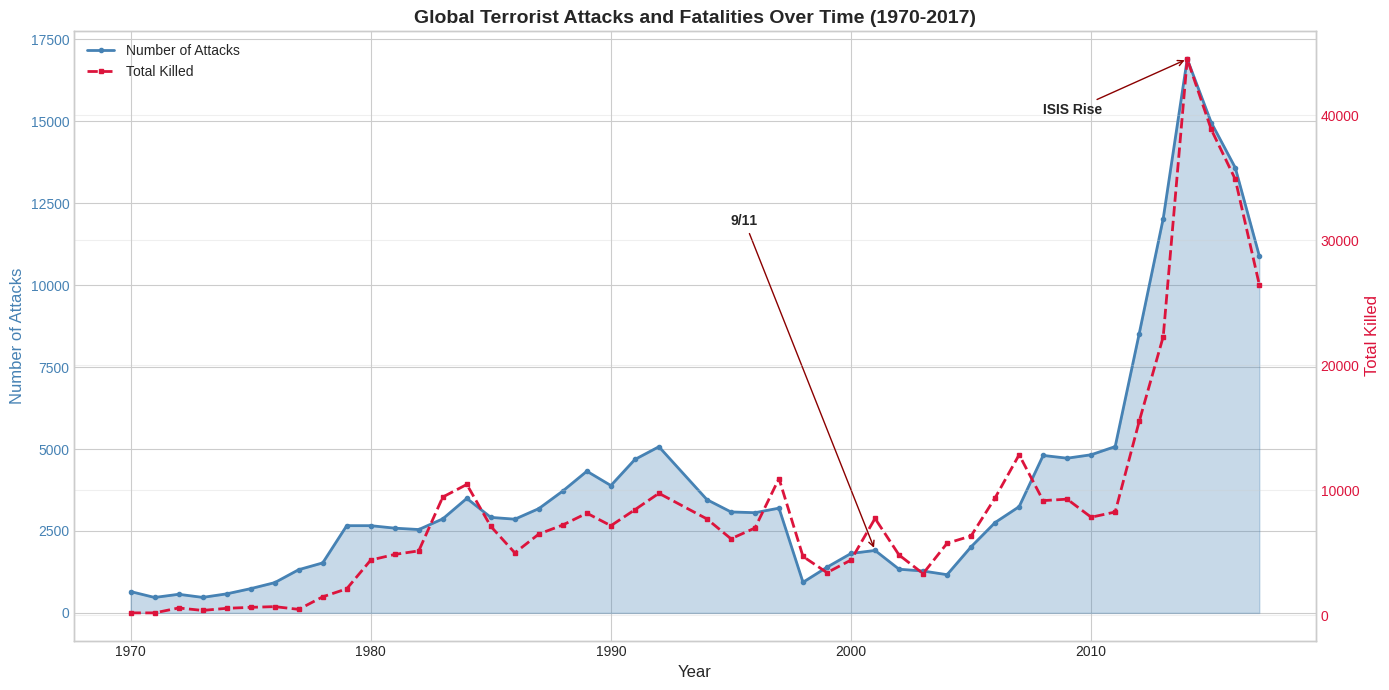


📊 Insight: Terrorist attacks peaked in 2014 with 16,903 attacks globally.


In [28]:
# Create figure with dual y-axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot number of attacks
color1 = 'steelblue'
ax1.fill_between(yearly_stats['year'], yearly_stats['num_attacks'], alpha=0.3, color=color1)
ax1.plot(yearly_stats['year'], yearly_stats['num_attacks'], color=color1, linewidth=2, marker='o', markersize=3, label='Number of Attacks')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Attacks', color=color1, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color1)

# Create second y-axis for casualties
ax2 = ax1.twinx()
color2 = 'crimson'
ax2.plot(yearly_stats['year'], yearly_stats['total_killed'], color=color2, linewidth=2, linestyle='--', marker='s', markersize=3, label='Total Killed')
ax2.set_ylabel('Total Killed', color=color2, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color2)

# Add annotations for significant events
# 9/11 (2001)
ax1.annotate('9/11', xy=(2001, yearly_stats[yearly_stats['year']==2001]['num_attacks'].values[0] if 2001 in yearly_stats['year'].values else 0),
             xytext=(1995, yearly_stats['num_attacks'].max()*0.7),
             fontsize=10, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='darkred'))

# ISIS rise (2014)
ax1.annotate('ISIS Rise', xy=(2014, yearly_stats[yearly_stats['year']==2014]['num_attacks'].values[0] if 2014 in yearly_stats['year'].values else 0),
             xytext=(2008, yearly_stats['num_attacks'].max()*0.9),
             fontsize=10, fontweight='bold',
             arrowprops=dict(arrowstyle='->', color='darkred'))

plt.title('Global Terrorist Attacks and Fatalities Over Time (1970-2017)', fontsize=14, fontweight='bold')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('viz1_attacks_over_time.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Insight: Terrorist attacks peaked in 2014 with {yearly_stats['num_attacks'].max():,} attacks globally.")

### Visualization 2: Attacks by Region (Pie + Bar Chart)

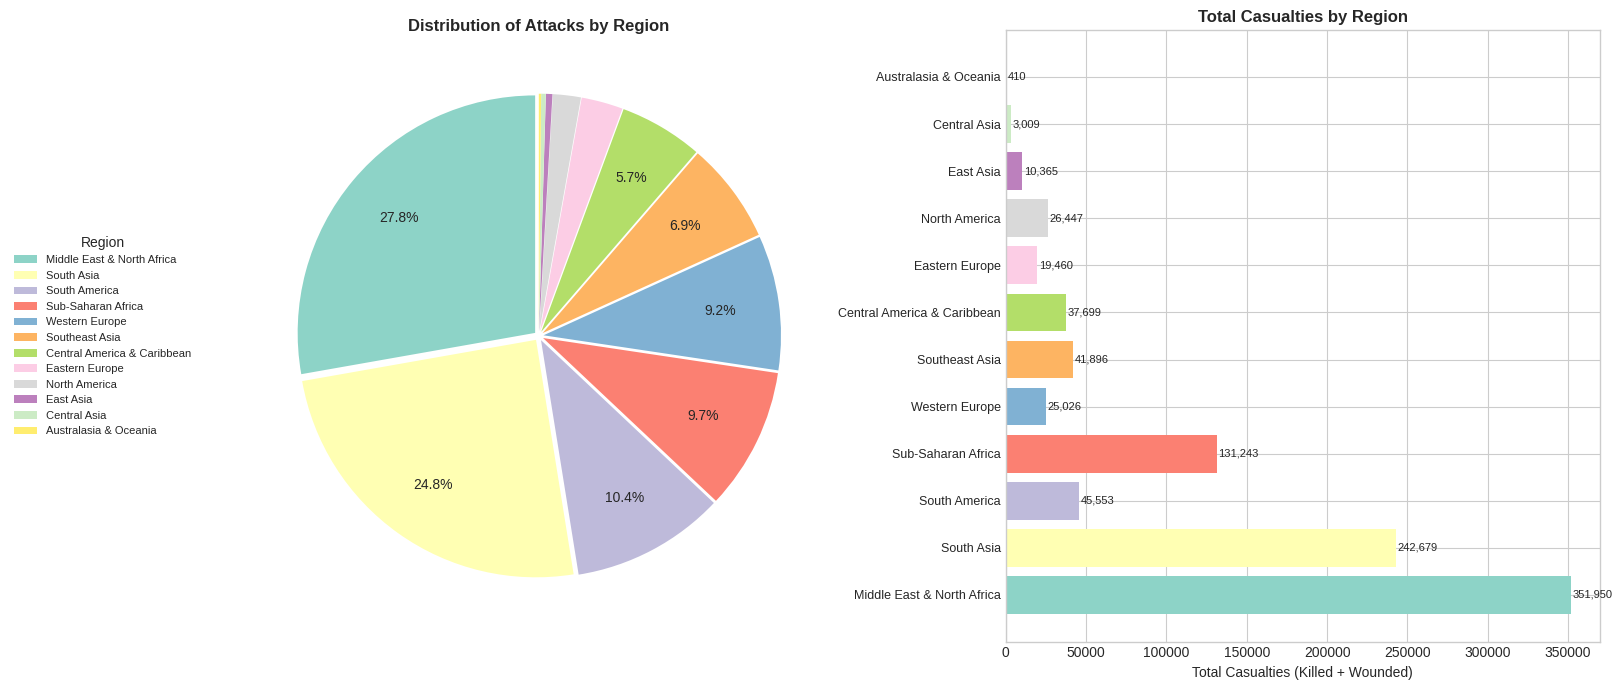


📊 Insight: Middle East & North Africa has the most attacks (50,474)


In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Pie chart - Number of attacks
colors = plt.cm.Set3(np.linspace(0, 1, len(region_stats)))
wedges, texts, autotexts = axes[0].pie(
    region_stats['num_attacks'].values,
    labels=None,
    autopct=lambda pct: f'{pct:.1f}%' if pct > 3 else '',
    colors=colors,
    startangle=90,
    pctdistance=0.75,
    explode=[0.02]*len(region_stats)
)
axes[0].legend(wedges, region_stats['region'].values, title="Region",
               loc="center left", bbox_to_anchor=(-0.4, 0.5), fontsize=8)
axes[0].set_title('Distribution of Attacks by Region', fontsize=12, fontweight='bold')

# Horizontal bar chart - Casualties
y_pos = np.arange(len(region_stats))
bars = axes[1].barh(y_pos, region_stats['total_casualties'], color=colors)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(region_stats['region'], fontsize=9)
axes[1].set_xlabel('Total Casualties (Killed + Wounded)')
axes[1].set_title('Total Casualties by Region', fontsize=12, fontweight='bold')

# Add value labels
for bar, val in zip(bars, region_stats['total_casualties']):
    axes[1].text(val + 1000, bar.get_y() + bar.get_height()/2, f'{val:,.0f}',
                 va='center', fontsize=8)

plt.tight_layout()
plt.savefig('viz2_region_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Insight: {region_stats.iloc[0]['region']} has the most attacks ({region_stats.iloc[0]['num_attacks']:,})")

### Visualization 3: Top 20 Countries by Attacks (Horizontal Bar Chart with Gradient)

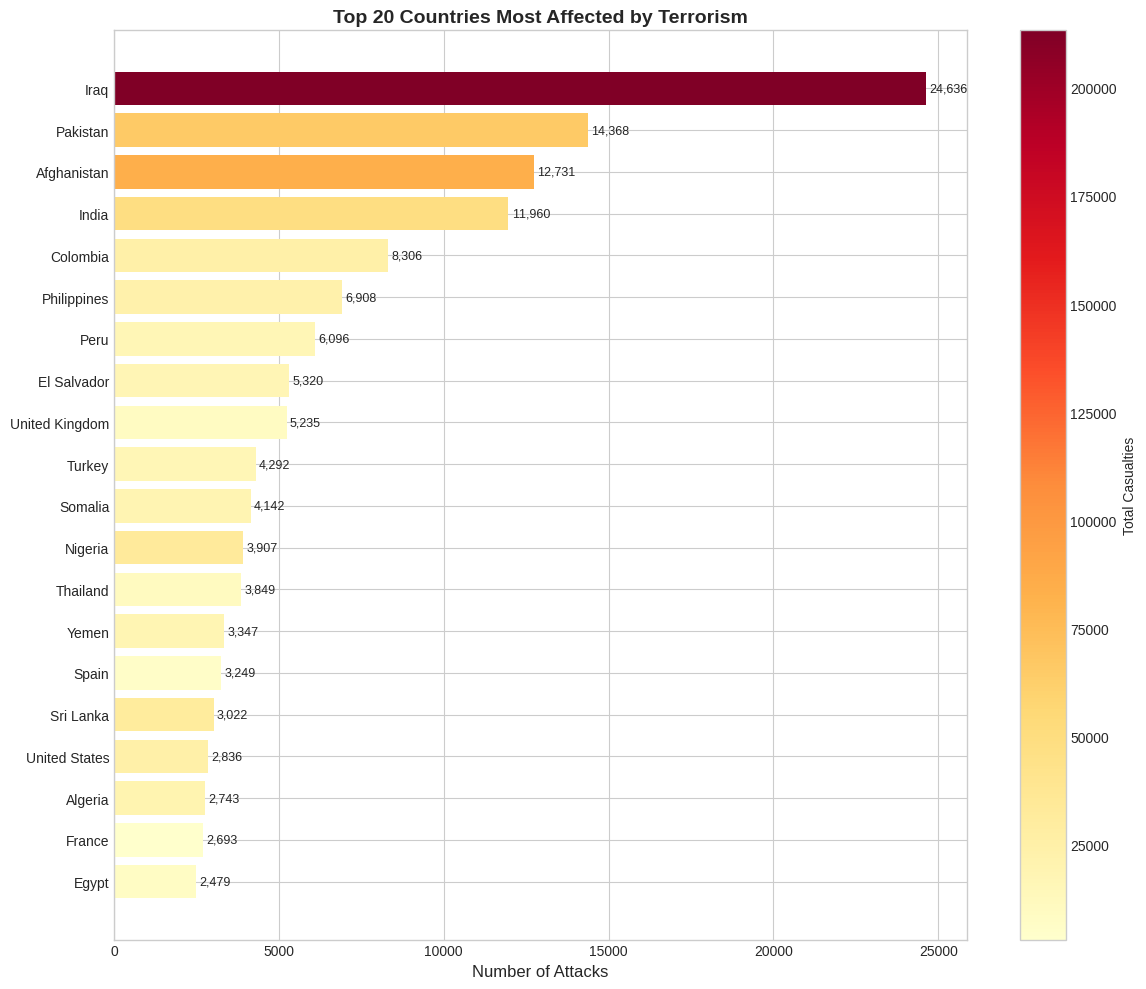


📊 Insight: Iraq has experienced the most terrorist attacks (24,636)


In [30]:
# Top 20 countries
top_20_countries = country_stats.head(20).copy()

plt.figure(figsize=(12, 10))

# Create color gradient based on casualties
norm = plt.Normalize(top_20_countries['total_casualties'].min(), top_20_countries['total_casualties'].max())
colors = plt.cm.YlOrRd(norm(top_20_countries['total_casualties']))

bars = plt.barh(range(len(top_20_countries)), top_20_countries['num_attacks'], color=colors)
plt.yticks(range(len(top_20_countries)), top_20_countries['country'])
plt.gca().invert_yaxis()
plt.xlabel('Number of Attacks', fontsize=12)
plt.title('Top 20 Countries Most Affected by Terrorism', fontsize=14, fontweight='bold')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), label='Total Casualties')

# Add value labels
for bar, val in zip(bars, top_20_countries['num_attacks']):
    plt.text(val + 100, bar.get_y() + bar.get_height()/2, f'{val:,}',
             va='center', fontsize=9)

plt.tight_layout()
plt.savefig('viz3_top_countries.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Insight: {top_20_countries.iloc[0]['country']} has experienced the most terrorist attacks ({top_20_countries.iloc[0]['num_attacks']:,})")

### Visualization 4: Monthly Attack Pattern (Polar/Radar Chart)

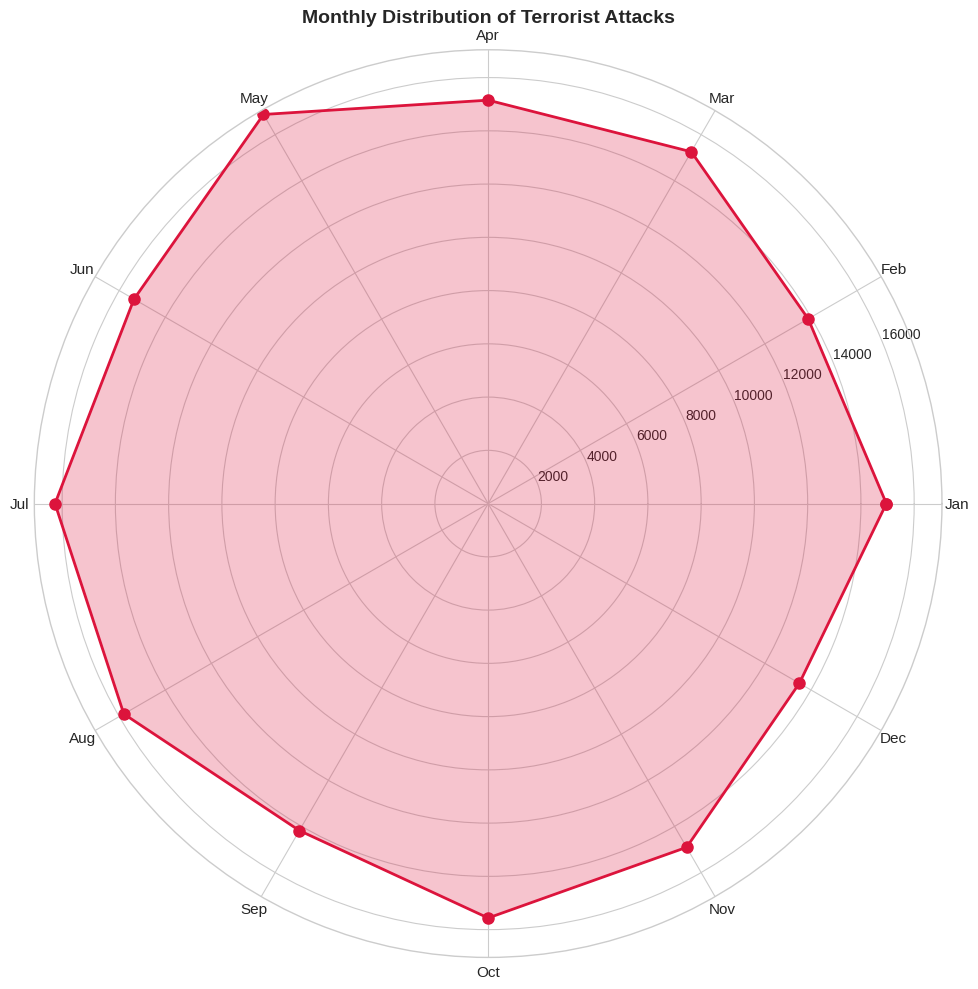


📊 Insight: May has the highest number of attacks. Attack distribution is relatively uniform across months.


In [31]:
# Monthly attack pattern
monthly_attacks = df.groupby('month').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create polar plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

# Angles for each month
angles = np.linspace(0, 2*np.pi, 12, endpoint=False)
values = monthly_attacks.values

# Close the polygon
angles = np.concatenate((angles, [angles[0]]))
values = np.concatenate((values, [values[0]]))

ax.plot(angles, values, 'o-', linewidth=2, color='crimson', markersize=8)
ax.fill(angles, values, alpha=0.25, color='crimson')

# Set labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(month_names, fontsize=11)
ax.set_title('Monthly Distribution of Terrorist Attacks', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('viz4_monthly_pattern.png', dpi=150, bbox_inches='tight')
plt.show()

peak_month = month_names[monthly_attacks.idxmax() - 1]
print(f"\n📊 Insight: {peak_month} has the highest number of attacks. Attack distribution is relatively uniform across months.")

### Visualization 5: Attack Type vs Success Rate (Scatter Plot)

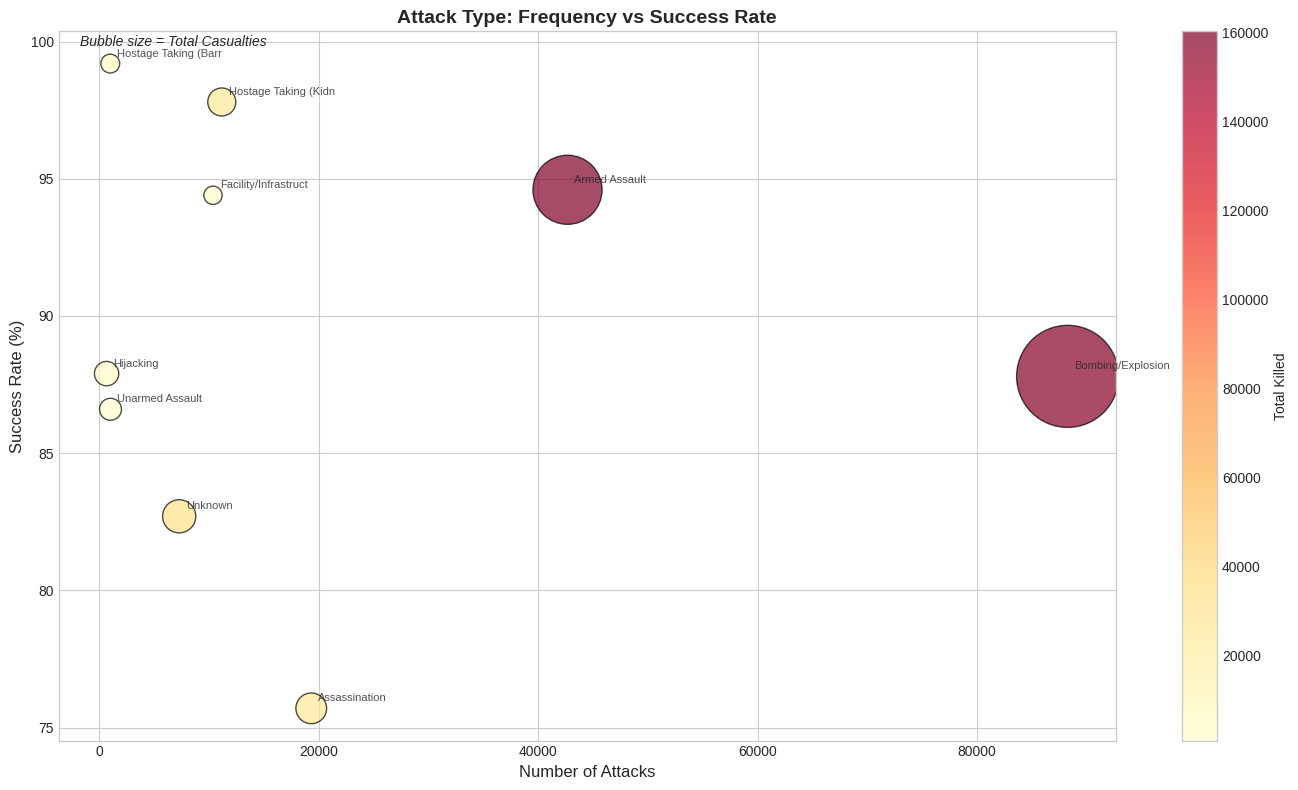


📊 Insight: Bombing/Explosion is the most common attack type with high success rate.


In [32]:
plt.figure(figsize=(14, 8))

# Create scatter plot
scatter = plt.scatter(
    attack_stats['num_attacks'],
    attack_stats['success_rate'],
    s=attack_stats['total_casualties'] / 100 + 100,  # Size by casualties
    c=attack_stats['total_killed'],
    cmap='YlOrRd',
    alpha=0.7,
    edgecolors='black',
    linewidth=1
)

# Add labels for each point
for i, row in attack_stats.iterrows():
    plt.annotate(row['attack_type'][:20],
                 xy=(row['num_attacks'], row['success_rate']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=8, alpha=0.8)

plt.colorbar(scatter, label='Total Killed')
plt.xlabel('Number of Attacks', fontsize=12)
plt.ylabel('Success Rate (%)', fontsize=12)
plt.title('Attack Type: Frequency vs Success Rate', fontsize=14, fontweight='bold')
plt.annotate('Bubble size = Total Casualties', xy=(0.02, 0.98), xycoords='axes fraction',
             fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('viz5_attack_type_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Insight: Bombing/Explosion is the most common attack type with high success rate.")

### Visualization 6: Attacks by Decade and Region (Grouped Bar Chart)

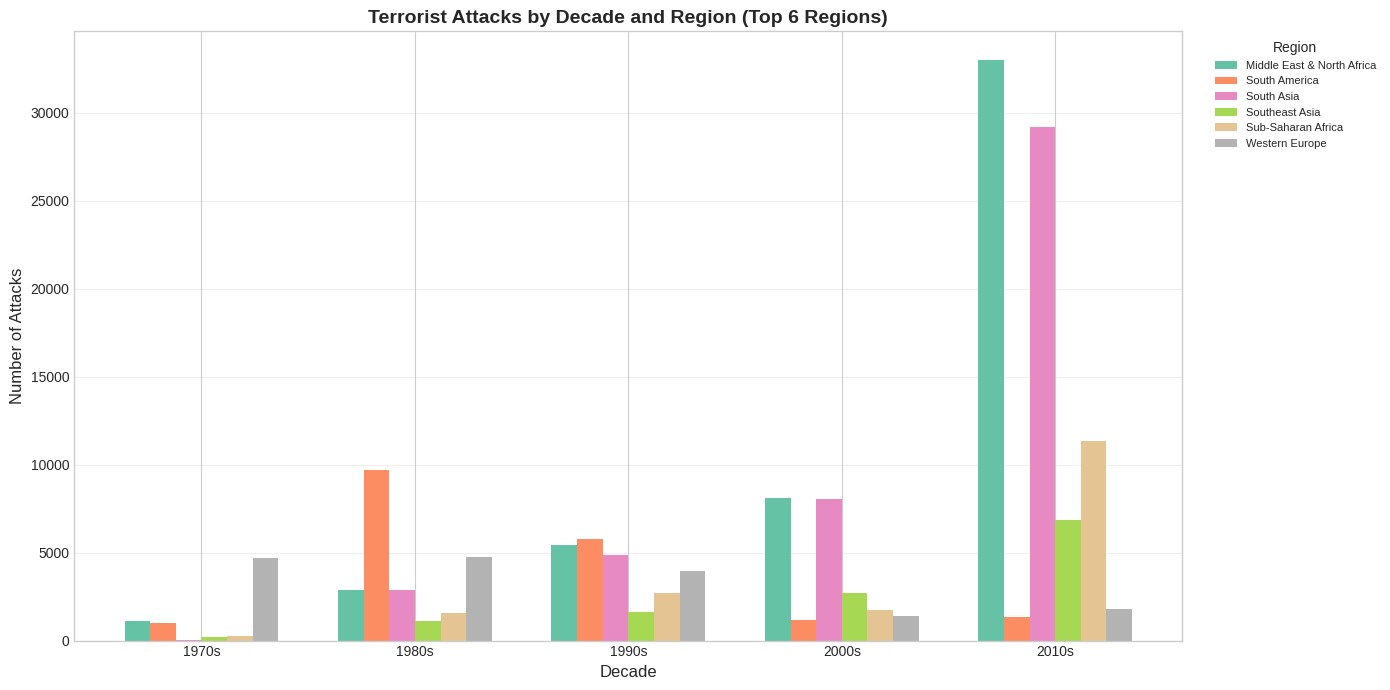


📊 Insight: Middle East & North Africa saw dramatic increase in attacks from 2000s onwards.


In [33]:
# Decade-Region breakdown
decade_region = df.groupby(['decade', 'region']).size().reset_index(name='num_attacks')

# Get top 6 regions
top_regions = region_stats.head(6)['region'].tolist()
decade_region_filtered = decade_region[decade_region['region'].isin(top_regions)]

# Pivot for grouped bar chart
decade_pivot = decade_region_filtered.pivot(index='decade', columns='region', values='num_attacks').fillna(0)

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(decade_pivot.index))
width = 0.12
colors = plt.cm.Set2(np.linspace(0, 1, len(decade_pivot.columns)))

for i, (region, color) in enumerate(zip(decade_pivot.columns, colors)):
    offset = width * i
    bars = ax.bar(x + offset, decade_pivot[region], width, label=region, color=color)

ax.set_xlabel('Decade', fontsize=12)
ax.set_ylabel('Number of Attacks', fontsize=12)
ax.set_title('Terrorist Attacks by Decade and Region (Top 6 Regions)', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2.5)
ax.set_xticklabels([f"{int(d)}s" for d in decade_pivot.index])
ax.legend(title='Region', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('viz6_decade_region.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Insight: Middle East & North Africa saw dramatic increase in attacks from 2000s onwards.")

### Visualization 7: Casualty Distribution by Attack Type (Box Plot)

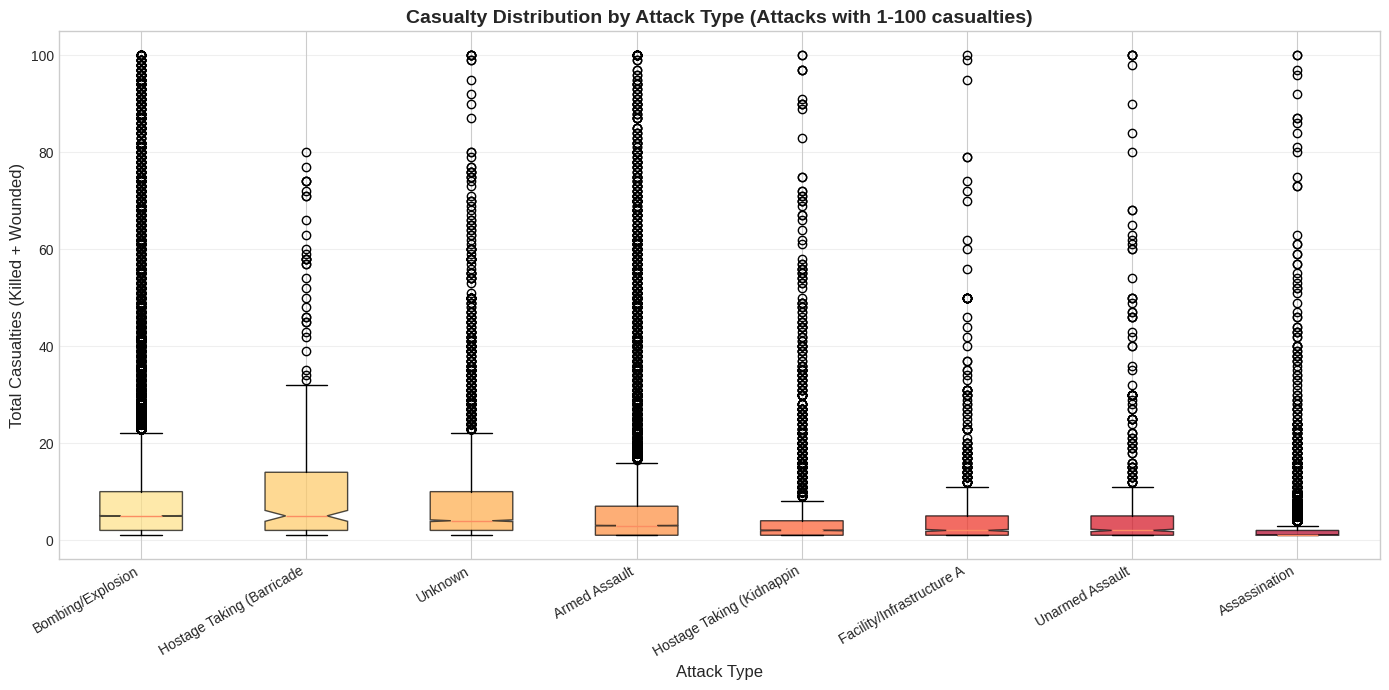


📊 Insight: Hijacking and Armed Assault have higher median casualties per attack.


In [34]:
# Filter to attacks with casualties and limit outliers for visibility
df_box = df[(df['total_casualties'] > 0) & (df['total_casualties'] <= 100)].copy()

# Get top 8 attack types
top_attack_types = attack_stats.head(8)['attack_type'].tolist()
df_box = df_box[df_box['attack_type'].isin(top_attack_types)]

plt.figure(figsize=(14, 7))

# Order by median casualties
order = df_box.groupby('attack_type')['total_casualties'].median().sort_values(ascending=False).index

# Create box plot
box_data = [df_box[df_box['attack_type'] == at]['total_casualties'] for at in order]

bp = plt.boxplot(box_data, labels=[at[:25] for at in order], patch_artist=True, notch=True)

# Color the boxes
colors = plt.cm.YlOrRd(np.linspace(0.2, 0.9, len(order)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('Total Casualties (Killed + Wounded)', fontsize=12)
plt.title('Casualty Distribution by Attack Type (Attacks with 1-100 casualties)', fontsize=14, fontweight='bold')
plt.xticks(rotation=30, ha='right')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('viz7_casualty_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Insight: Hijacking and Armed Assault have higher median casualties per attack.")

### Visualization 8: Region × Attack Type Heatmap

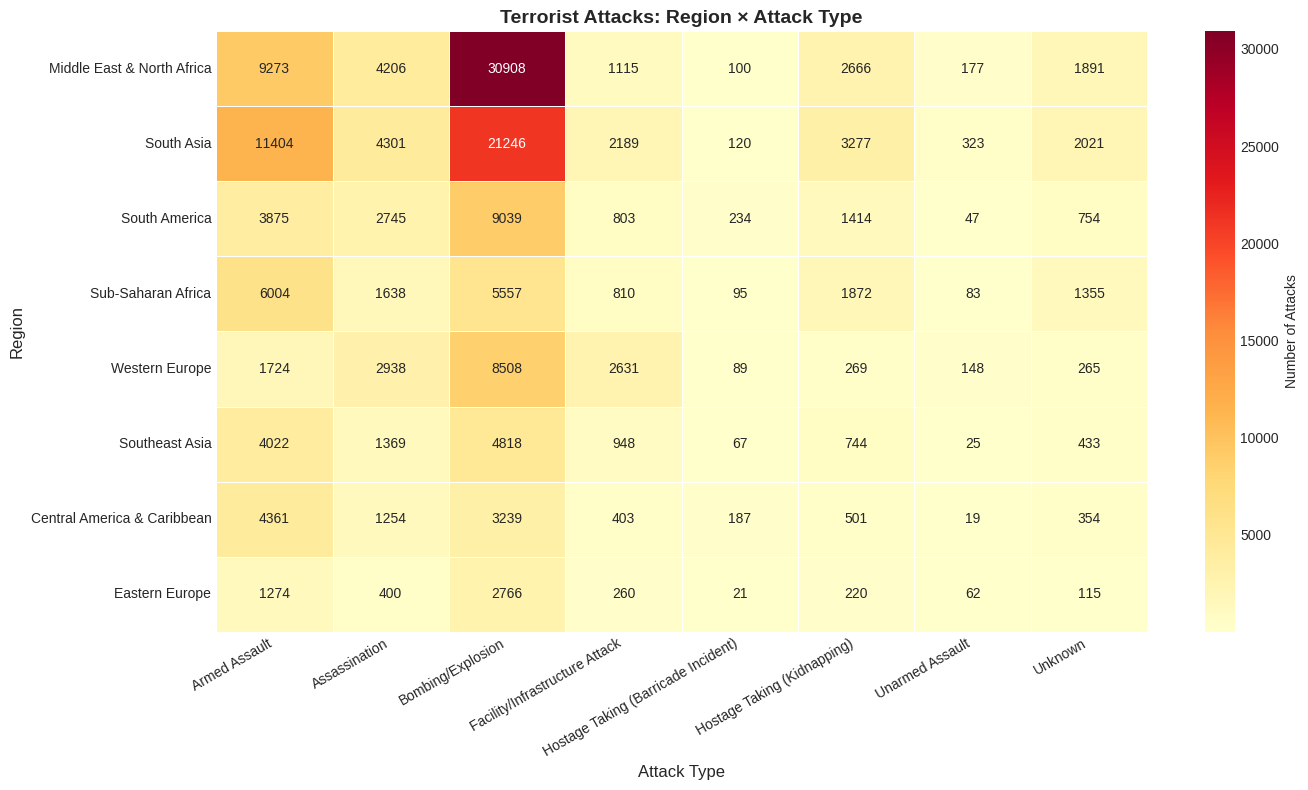


📊 Insight: Bombing/Explosion dominates across all regions, particularly in Middle East & South Asia.


In [35]:
# Create region-attack type pivot
region_attack = df.groupby(['region', 'attack_type']).size().reset_index(name='count')

# Get top regions and attack types
top_regions = region_stats.head(8)['region'].tolist()
top_attacks = attack_stats.head(8)['attack_type'].tolist()

region_attack_filtered = region_attack[
    (region_attack['region'].isin(top_regions)) &
    (region_attack['attack_type'].isin(top_attacks))
]

# Pivot for heatmap
heatmap_data = region_attack_filtered.pivot(index='region', columns='attack_type', values='count').fillna(0)

# Sort by total
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd',
            cbar_kws={'label': 'Number of Attacks'},
            linewidths=0.5)
plt.title('Terrorist Attacks: Region × Attack Type', fontsize=14, fontweight='bold')
plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.savefig('viz8_region_attack_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Insight: Bombing/Explosion dominates across all regions, particularly in Middle East & South Asia.")

---
## 6. Interactive Visualizations with Plotly

In [36]:
# Interactive time series
fig = px.line(yearly_stats, x='year', y='num_attacks',
              title='Interactive: Global Terrorist Attacks Over Time',
              labels={'year': 'Year', 'num_attacks': 'Number of Attacks'})
fig.add_scatter(x=yearly_stats['year'], y=yearly_stats['total_killed'],
                mode='lines', name='Total Killed', line=dict(dash='dash', color='red'))
fig.update_layout(hovermode='x unified')
fig.show()

In [37]:
# Interactive world map
# Sample data for performance
df_map = df[df['latitude'].notna() & df['longitude'].notna()].copy()
df_map = df_map.sample(n=min(10000, len(df_map)), random_state=42)

fig = px.scatter_geo(df_map,
                     lat='latitude',
                     lon='longitude',
                     color='attack_type',
                     size='total_casualties',
                     hover_name='city',
                     hover_data=['country', 'year', 'group_name', 'nkill'],
                     title='Global Terrorism: Attack Locations (Sample)',
                     size_max=20)
fig.update_layout(geo=dict(showframe=False, projection_type='natural earth'))
fig.show()

In [38]:
# Interactive choropleth - Attacks by country
fig = px.choropleth(country_stats.head(50),
                    locations='country',
                    locationmode='country names',
                    color='num_attacks',
                    hover_name='country',
                    hover_data=['total_killed', 'total_casualties'],
                    color_continuous_scale='YlOrRd',
                    title='Terrorist Attacks by Country (Top 50)')
fig.update_layout(geo=dict(showframe=False))
fig.show()

In [39]:
# Interactive sunburst - Region > Country > Attack Type
top_data = df.groupby(['region', 'country', 'attack_type']).size().reset_index(name='count')
top_data = top_data[top_data['count'] > 100]  # Filter for performance

fig = px.sunburst(top_data, path=['region', 'country', 'attack_type'], values='count',
                  title='Hierarchical View: Region → Country → Attack Type',
                  color='count', color_continuous_scale='YlOrRd')
fig.show()

In [40]:
# Animated bar chart - Top 10 countries over decades
decade_country = df.groupby(['decade', 'country']).size().reset_index(name='num_attacks')
top_per_decade = decade_country.groupby('decade').apply(
    lambda x: x.nlargest(10, 'num_attacks')
).reset_index(drop=True)

fig = px.bar(top_per_decade, x='num_attacks', y='country',
             animation_frame='decade', orientation='h',
             color='num_attacks', color_continuous_scale='YlOrRd',
             title='Top 10 Countries by Terrorist Attacks (by Decade)',
             labels={'num_attacks': 'Number of Attacks', 'country': 'Country'},
             range_x=[0, top_per_decade['num_attacks'].max() * 1.1])
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()